# Flo11 Model

### Import modules and mount drive

In [ ]:
# Import drive to be able to download and upload plot files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import time
from scipy.sparse import kron, eye
from scipy.linalg import toeplitz
import numpy as np
import matplotlib.pyplot as plt
from decimal import *
getcontext().prec = 15
from google.colab import files
from moviepy.editor import *
import os
import glob

## Functions for calculations

In [ ]:
# Parameters list

steps = 5000
Nx=50
Ny=50
dx=1
dy=1
ncell=15
ntype=2
R=2
Rmax=14
dt=0.003
growth_rate=0.2
a=1
friction=1500
ucost=60
lamda=12
pix = 4.0*math.atan(1.0)


In [ ]:
def lapl(Nx, Ny, dx, dy):
  nxny = Nx * Ny
  r = np.zeros(Nx)
  r[0:2] = [2, -1]
  T = np.matrix(toeplitz(r))
  E = np.asmatrix(eye(Nx).toarray())
  grad = -(kron(T, E) + kron(E, T))

  # periodic
  for i in range(Nx):
    ii = (i) * Nx
    jj = ii + Nx -1
    grad[ii, jj] = 1.0
    grad[jj, ii] = 1.0

    kk = nxny - Nx +i
    grad[i, kk] = 1.0
    grad[kk, i] = 1.0

  grad = grad / (dx * dy)
  return grad

In [ ]:
def generate (Nx, Ny, ncell, R, stiffA, stiffB, kapA, kapB, xgrid, ygrid):
  #iniciate
  phase = np.zeros((Nx, Ny, ncell))
  clabel = np.zeros((1,1,ncell))
  ccorr= []
  friction = np.zeros((1,1,ncell))
  stifness = np.zeros((1,1,ncell))
  kappa = np.zeros((1,1,ncell))

  icell = 0
  type1 = 1
  type2 = 1

  for i in range(1, 100001):
    if icell == ncell:
      break

    #strain 1
    if (i<= (ncell/2)+1):
      xc=(Nx/2)-2
      yc= type1
      stifness[0,0,icell]=stiffA

      kappa[0,0,icell]=kapA
      type1=type1+3*R

    #strain 2
    if (i> (ncell/2)+1):
      xc=(Nx/2)+2
      yc= type2
      stifness[0,0,icell]=stiffB
      kappa[0,0,icell]=kapB
      type2=type2+3*R

    if (((xc-R) > 0) and ((xc+R) < Nx) and ((yc-R) > 0) and ((yc+R) < Ny)):
      ccorr.append([xc, yc, R])
      mask = ((xgrid-xc)**2 + (ygrid-yc)**2) < R**2
      phase[:,:,icell] = mask * 0.999
      icell=icell+1

  phase[phase > 0.999] = 0.999
  phase[phase < 0] = 0.0

  return phase, icell, stifness, ccorr, kappa

In [ ]:
def FieldP(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB):
    xgrid, ygrid = np.meshgrid(np.arange(0, Nx), np.arange(0, Ny))
    laplace = lapl(Nx, Ny, dx, dy)
    # Generate initial values
    domain_phase, domain_icell, domain_stifness, domain_ccorr, domain_kappa = generate (Nx, Ny, ncell, R, stiffnessA, stiffnessB, kappaA, kappaB, xgrid, ygrid)
    return domain_phase.transpose((1, 0, 2)), domain_icell, domain_stifness, np.array(domain_ccorr), domain_kappa, laplace

In [ ]:
def vec2matx(V, N):

  V = V.T
  #V = np.matrix(V).getH()
  V = V.flatten()

  #V = V.reshape(-1, 1)
  R = math.ceil(len(V) / N)
  #R = -(-V.size // N)  # ceiling division
  M = np.reshape(V,[N, R]).T  # pad the final row with zeros if necessary
  return M

In [ ]:
def calcGradient (A, Nx, Ny, dx, dy):
  Adx, Ady = np.gradient(A, edge_order=2)

  #periodic
  Adx[0:Nx,0] = 0.5 * (A[0:Nx,1] - A[0:Nx,Ny-1])
  Adx[0:Nx,Ny-1] = 0.5 * (A[:,0] - A[0:Nx,Ny-2])
  Ady[0,0:Ny] = 0.5 * (A[1,:] - A[Nx-1,0:Ny])
  Ady[Nx-1,0:Ny] = 0.5 * (A[0,:] - A[Nx-2,0:Ny])

  Adx = 2.0*Adx/dx
  Ady = 2.0*Ady/dy

  return Adx, Ady

In [ ]:
# Function that calculates new domain_phase for each cell given last domain_phase
def calculate (domain_phase, domain_kappa, domain_icell, domain_ccorr, domain_stifness, domain_laplace, Nx, Ny, dx, dy, lamda, ucost, pix, dt, friction):
  for jcell in range (0, domain_icell):
    #per colony
    cellF = domain_phase[:,:,jcell]
    #print (cellF[:,6])
    cellSTIFF = domain_stifness[0,0,jcell]

    actual_radius=domain_ccorr[jcell,2]

    #calculate laplacian
    lap_cell2= domain_laplace*(np.reshape((cellF.T), (Nx*Ny, 1)))
    lap_cell=vec2matx(lap_cell2,Nx)
    #print(lap_cell[:,6])


    #calculate gradients
    phidy,phidx=calcGradient(cellF,Nx,Ny,dx,dy)
    #print (phidy[:,6])

    #calculate integrals

    sum_phi= np.zeros((Nx,Ny))

    sum_phi = np.sum(domain_phase[:,:,0:jcell]**2*domain_kappa[0,0,0:jcell], axis=2) + np.sum(domain_phase[:,:,jcell+1:]**2*domain_kappa[0,0,jcell+1:], axis=2)



    vintegx = np.sum(np.sum(phidx*cellF*sum_phi))
    vintegy = np.sum(np.sum(phidy*cellF*sum_phi))



    #calculate free energy (bistable field 0,1)

    freeenergy = cellSTIFF*cellF*(1.0-cellF)*(1.0-2.0*cellF) + 2.0*cellF*sum_phi
    #print(freeenergy[:,6])

    #calculate shape cost term due to growth

    shape = (1/(actual_radius**2))*cellF*(np.sum(np.sum(cellF**2)) - pix*(actual_radius**2))
    #print(shape[:,6])
    #shape=0
    #calculate velocities due to cell interactions


    velocity = (1/friction)*(vintegx*phidx + vintegy*phidy)
    #velocity=0;
    #integration forward Euler FD

    # For 1 step and first cell answer is good as velocity is 0
    newphi = cellF + dt*(cellSTIFF*lap_cell - (30/(lamda**2))*freeenergy - (2*ucost/pix)*shape - ((60)/(lamda**2))*velocity)
    domain_phase[:,:,jcell] = newphi

  return domain_phase

In [ ]:
# Function that generates initial distribution and iterates over time
def iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save):
  tic = time.time()
  #make initial colony distribution
  domain_phase, domain_icell, domain_stifness, domain_ccorr, domain_kappa, domain_laplace = FieldP(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB)

  for i in range (0, steps): #time steps
    domain_phase = calculate(domain_phase, domain_kappa, domain_icell, domain_ccorr, domain_stifness, domain_laplace, Nx, Ny, dx, dy, lamda, ucost, pix, dt, friction)
    #grow colonies
    if save == 0:
      plot(domain_phase,  stiffnessA, stiffnessB, kappaA, kappaB, images_dir, i, save)
    if (domain_ccorr[:,2] < Rmax).all():
      domain_ccorr[:,2] =  domain_ccorr[:,2]+dt*growth_rate

  elapsed = time.time() - tic
  return domain_phase, elapsed

In [ ]:
# Function to create plot with legends and option to save the plot if indicated
def plot(domain_phase, stiffnessA, stiffnessB, kappaA, kappaB, images_dir, step, save):
  plt.figure(1)
  plt.xticks(np.arange(0, Nx +1, step=5))
  plt.yticks(np.arange(0, Ny +1, step=5))
  plt.imshow(np.sum(domain_phase, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0])

  # Set figure title and data box
  plt.suptitle('Interaction of Cenpk + BY consortia', style = "italic", fontsize = 15)
  plt.title('Step %.f' %(step, ))
  textstr = '\n'.join((
      r'$BY:$ $stiffness$ $=$ $%.f$ $,  interaction$ $rate$ $=$ $%.f$' % (stiffnessA, kappaA, ),
      r'$Cenpk:$ $stiffness$ $=$ $%.f$ $, interaction$ $rate$ $=$ $%.f$' % (stiffnessB, kappaB, )))
      #r'$BY$ $interaction$ $rate$ $=$ $%.f$' % (kappaA, ),
      #r'$Cenpk$ $interaction$ $rate$ $=$ $%.f$' % (kappaB, )))
  plt.text(4, 60, textstr,fontsize=10, bbox=dict(boxstyle="square",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    ))
  #plt.text(65, 13.5, '          Parameters          ',fontsize=12, bbox=dict(boxstyle="round",
  #                  ec='black',
  #                  fc=(1., 0.5, 0.5),
  #                  ))
  fig_name = 'Step%.f' %(step, )
  plt.colorbar()
  if  save == 0:
    plt.savefig(f"{images_dir}/{fig_name}.png", bbox_inches="tight")
    # Optional line code to download the images to the PC
    #files.download(f"{images_dir}/{fig_name}.png")
    plt.close()
  plt.show()

## Initial display

In [ ]:
kappaA=2
kappaB=20
stiffnessA=2
stiffnessB=20
#make initial colony distribution
domain_phase, domain_icell, domain_stifness, domain_ccorr, domain_kappa, domain_laplace = FieldP(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB)

  self._set_intXint(row, col, x.flat[0])



Initial colony sitribution, the left column of cells corresponds to By strain cells and the right one to Cenpk strain cells.

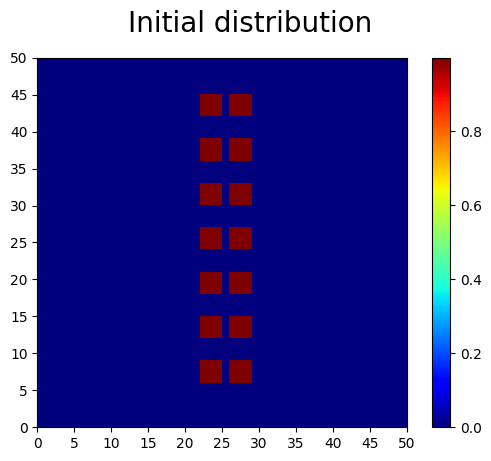

In [ ]:
plt.figure(1)
plt.xticks(np.arange(0, Nx +1, step=5))
plt.yticks(np.arange(0, Ny +1, step=5))
plt.imshow((np.sum(domain_phase, axis=2).T), origin='lower', cmap='jet', extent = [0, Nx, 0, Ny])
plt.suptitle('Initial distribution', fontsize = 20)
plt.colorbar()
plt.show()

## Repressentation

In [ ]:
#  Value 0 if we want to save all plots and value 1 if not
save = 1

### Control case: BY (stiffnes 2, kappa 2) - cenpk (stiffnes 20, kappa 20)

In [ ]:
# Important parameters
kappaA=2
kappaB=20
stiffnessA=2
stiffnessB=20
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Control_Case'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase0, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


In [ ]:
elapsed

50.629687547683716

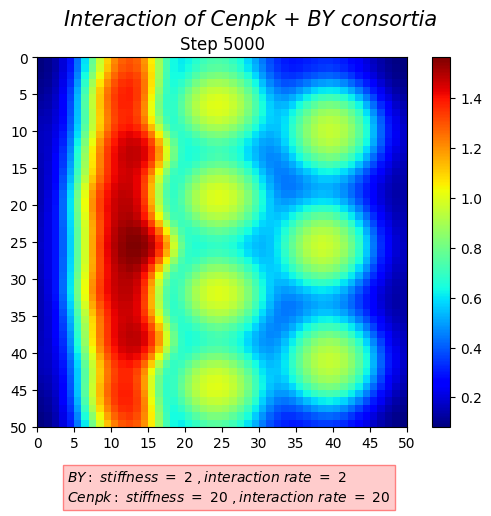

In [ ]:
image_dir = '/content/drive/MyDrive/Marta/Flo11 Model'
plot(domain_phase0, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 1: BY (stiffnes 2, kappa 20) - cenpk (stiffnes 20, kappa 20)

In [ ]:
# Important parameters
kappaA=20
kappaB=20
stiffnessA=2
stiffnessB=20
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case1'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase1, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


In [ ]:
elapsed/60

0.8260755896568298

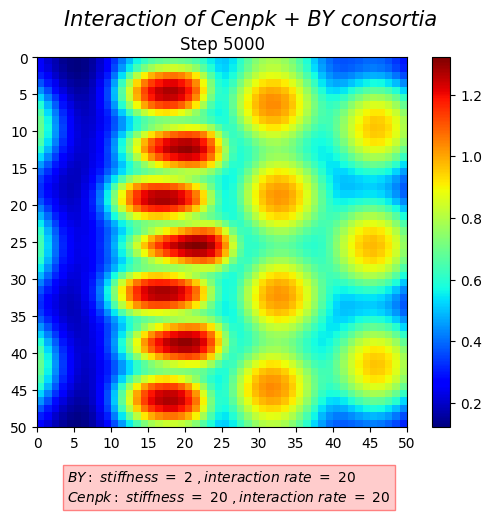

In [ ]:
plot(domain_phase1, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 2: BY (stiffnes 2, kappa 2) - cenpk (stiffnes 20, kappa 2)

In [ ]:
# Important parameters
kappaA=2
kappaB=2
stiffnessA=2
stiffnessB=20
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case2'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase2, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


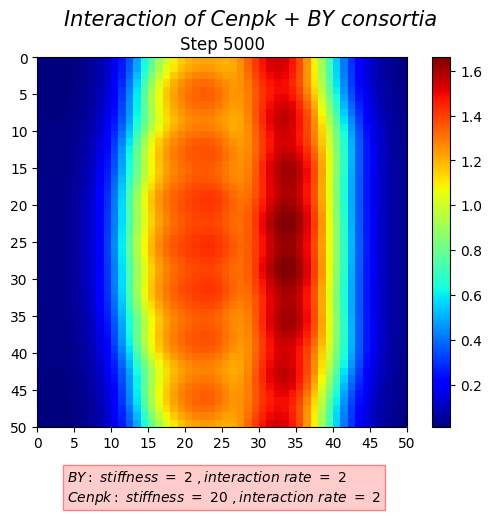

In [ ]:
plot(domain_phase2, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 3: BY (stiffnes 20, kappa 2) - cenpk (stiffnes 20, kappa 20)

In [ ]:
# Important parameters
kappaA=2
kappaB=20
stiffnessA=20
stiffnessB=20
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case3'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase3, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


In [ ]:
elapsed

49.55842733383179

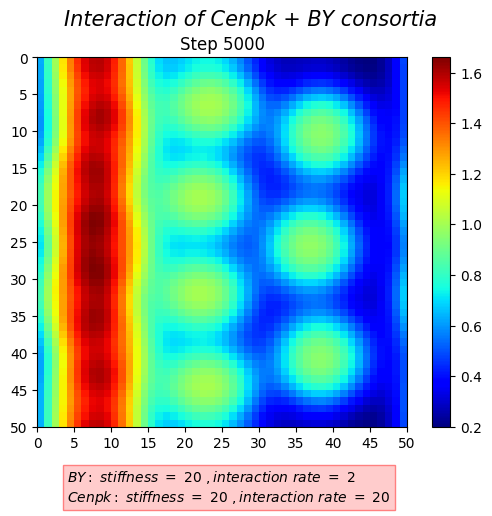

In [ ]:
plot(domain_phase3, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 4: BY (stiffnes 2, kappa 2) - cenpk (stiffnes 2, kappa 20)

In [ ]:
# Important parameters
kappaA=2
kappaB=20
stiffnessA=2
stiffnessB=2
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case4'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase4, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


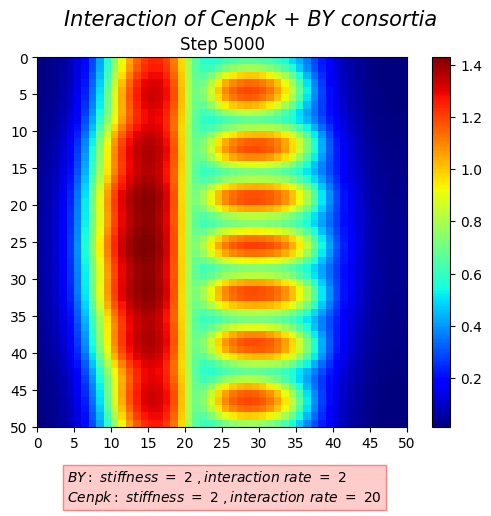

In [ ]:
plot(domain_phase4, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 5: BY (stiffnes 20, kappa 20) - cenpk (stiffnes 20, kappa 20)

In [ ]:
# Important parameters
kappaA=20
kappaB=20
stiffnessA=20
stiffnessB=20
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case5'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase5, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)

In [ ]:
elapsed

49.128461837768555

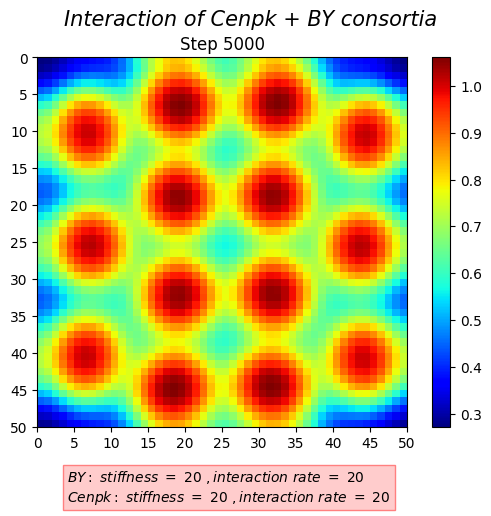

In [ ]:
plot(domain_phase5, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 6: BY (stiffnes 2, kappa 2) - cenpk (stiffnes 2, kappa 2)

In [ ]:
# Important parameters
kappaA=2
kappaB=2
stiffnessA=2
stiffnessB=2
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case6'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase6, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


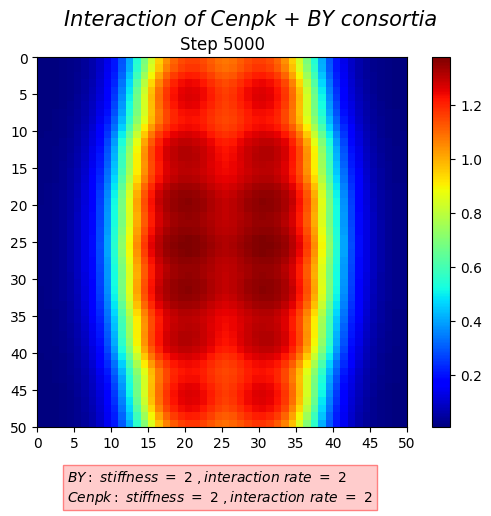

In [ ]:
plot(domain_phase6, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 7: BY (stiffnes 2, kappa 20) - cenpk (stiffnes 2, kappa 20)

In [ ]:
# Important parameters
kappaA=20
kappaB=20
stiffnessA=2
stiffnessB=2
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case7'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase7, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


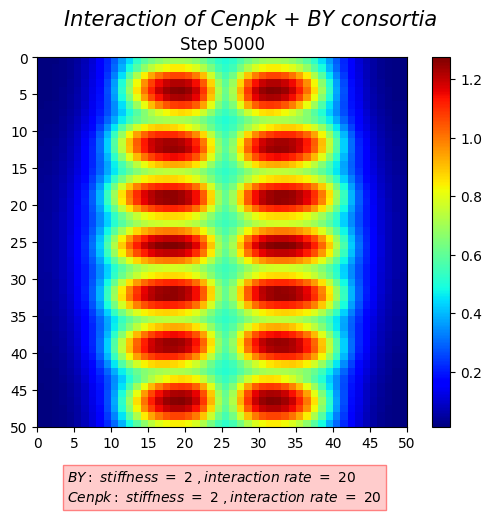

In [ ]:
plot(domain_phase7, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

### Case 8: BY (stiffnes 20, kappa 2) - cenpk (stiffnes 20, kappa 2)

In [ ]:
# Important parameters
kappaA=2
kappaB=2
stiffnessA=20
stiffnessB=20
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Case8'
if save == 0:
  os.mkdir(images_dir)

In [ ]:
domain_phase8, elapsed = iterate_over_time(Nx, Ny, dx, dy, ncell, ntype, R, kappaA, kappaB, stiffnessA, stiffnessB, lamda, ucost, pix, dt, friction, steps, images_dir, save)


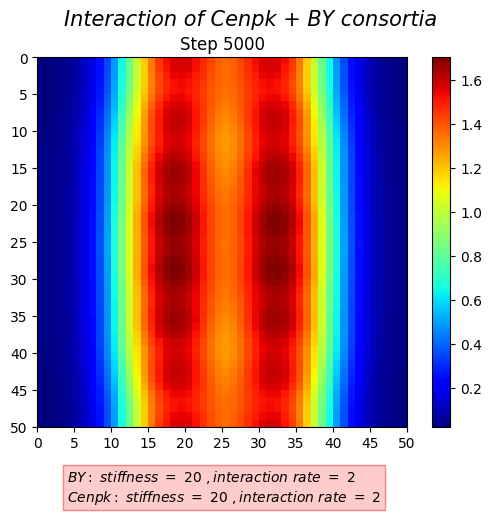

In [ ]:
plot(domain_phase8, stiffnessA, stiffnessB, kappaA, kappaB, image_dir, 5000, 1)

## RESULTS

### Video

The Final Video can be seen in the folder Videos, but there are a couple videos that skip some initial steps (Don't know why) and end earlier.

The following code would produce a video of the image sequence using moviepy but it consumes all RAM and disconects the envioroment

In [ ]:
#fps = 100
#clips = []
#file_list = glob.glob(f"{images_dir}/*.png")  # Get all the pngs in the current directory

#for filename in file_list:
#  clips.append(ImageClip(filename).set_duration(1))

#concat_clip = concatenate_videoclips(clips, method="compose")
#concat_clip.write_videofile(f"{images_dir}/test.mp4", fps=fps)

To solve this problem I downloaded the images and created the video using ImageJ and uploaded to a Videos Folder

In [ ]:
videos_dir = '/content/drive/MyDrive/Marta/Flo11 Model/Videos'

path=f"{videos_dir}/Control_Case.avi"
clip0=VideoFileClip(path)

path=f"{videos_dir}/Case1.avi"
clip1=VideoFileClip(path)

path=f"{videos_dir}/Case2.avi"
clip2=VideoFileClip(path)

path=f"{videos_dir}/Case3.avi"
clip3=VideoFileClip(path)

path=f"{videos_dir}/Case4.avi"
clip4=VideoFileClip(path)

path=f"{videos_dir}/Case5.avi"
clip5=VideoFileClip(path)

path=f"{videos_dir}/Case6.avi"
clip6=VideoFileClip(path)

#clip0.ipython_display(width=500) # To display video

Execute code to generate a Final Video combinationg all cases avove

In [ ]:
# As there is an uneven number of clips, I have to creat some blank clips to display
Clipx = ColorClip(color = [0,0,0], size = (511, 536), duration = 50)

In [ ]:
# list of clips
clips = [[clip0, clip1, clip2],
        [clip3, clip4, clip5],
        [clip6, Clipx, Clipx]]


# stacking clips
final = clips_array(clips)

final.write_videofile(f"{videos_dir}/FinalVideo2.mp4")

# showing final clip
final.ipython_display(width = 1000)

The Final Video can be seen in the folder Videos, but there are a couple videos that skip some initial steps (Don't know why) and end earlier.

### Plot

Final Plot combining all results above. Can be seen here or in the Drive Folder

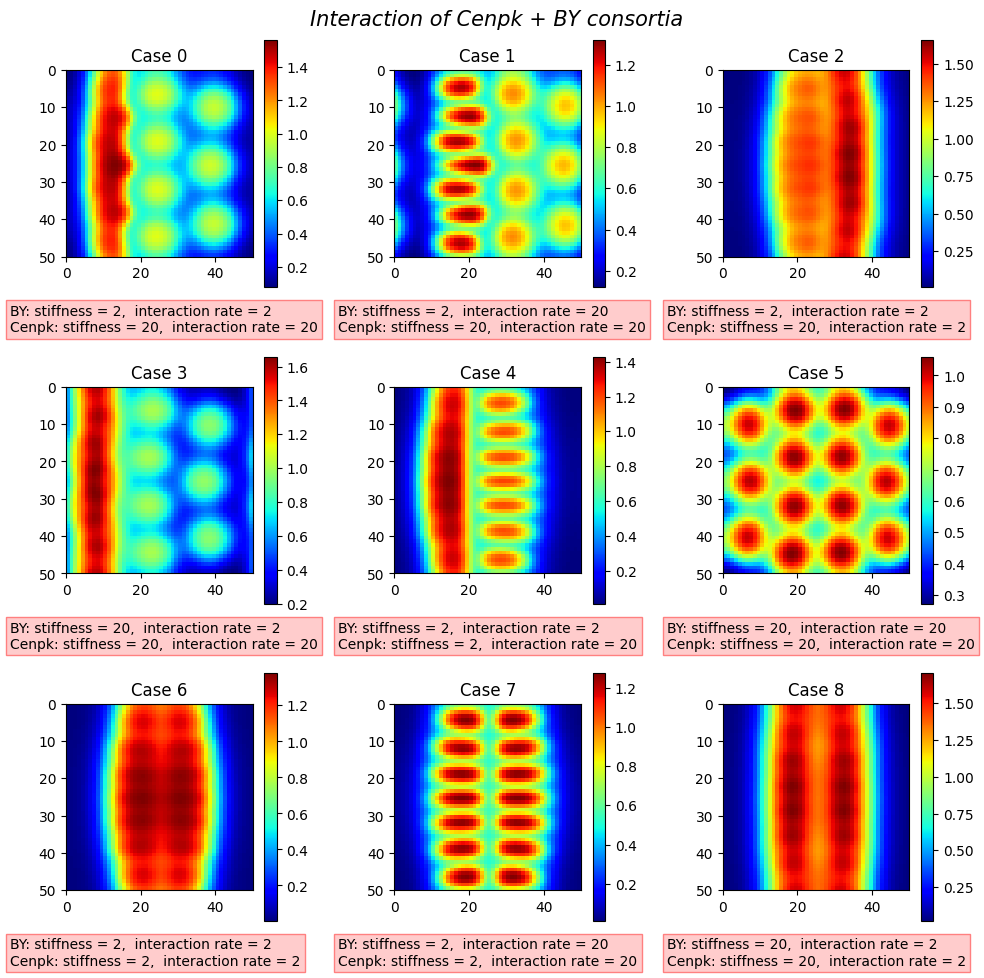

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

im0 = axs[0,0].imshow(np.sum(domain_phase0, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im0, ax=axs[0, 0])
im1 = axs[0,1].imshow(np.sum(domain_phase1, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im1, ax=axs[0, 1])
im2 = axs[0,2].imshow(np.sum(domain_phase2, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im2, ax=axs[0, 2])
im3 = axs[1,0].imshow(np.sum(domain_phase3, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im3, ax=axs[1, 0])
im4 = axs[1,1].imshow(np.sum(domain_phase4, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im4, ax=axs[1, 1])
im5 = axs[1,2].imshow(np.sum(domain_phase5, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im5, ax=axs[1, 2])
im6 = axs[2,0].imshow(np.sum(domain_phase6, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im6, ax=axs[2, 0])
im7 = axs[2,1].imshow(np.sum(domain_phase7, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im7, ax=axs[2, 1])
im8 = axs[2,2].imshow(np.sum(domain_phase8, axis=2).T, cmap='jet', extent = [0, Nx, Ny, 0]); plt.colorbar(im8, ax=axs[2, 2])


#im8 = axs[2,2].set_axis_off()


axs[0,0].set_title('Case 0')
axs[0,0].text(-15,70, 'BY: stiffness = 2,  interaction rate = 2\nCenpk: stiffness = 20,  interaction rate = 20',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[0,1].set_title('Case 1')
axs[0,1].text(-15,70, 'BY: stiffness = 2,  interaction rate = 20\nCenpk: stiffness = 20,  interaction rate = 20',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[0,2].set_title('Case 2')
axs[0,2].text(-15,70, 'BY: stiffness = 2,  interaction rate = 2\nCenpk: stiffness = 20,  interaction rate = 2',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[1,0].set_title('Case 3')
axs[1,0].text(-15,70, 'BY: stiffness = 20,  interaction rate = 2\nCenpk: stiffness = 20,  interaction rate = 20',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[1,1].set_title('Case 4')
axs[1,1].text(-15,70, 'BY: stiffness = 2,  interaction rate = 2\nCenpk: stiffness = 2,  interaction rate = 20',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[1,2].set_title('Case 5')
axs[1,2].text(-15,70, 'BY: stiffness = 20,  interaction rate = 20\nCenpk: stiffness = 20,  interaction rate = 20',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[2,0].set_title('Case 6')
axs[2,0].text(-15,70, 'BY: stiffness = 2,  interaction rate = 2\nCenpk: stiffness = 2,  interaction rate = 2',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[2,1].set_title('Case 7')
axs[2,1].text(-15,70, 'BY: stiffness = 2,  interaction rate = 20\nCenpk: stiffness = 2,  interaction rate = 20',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
axs[2,2].set_title('Case 8')
axs[2,2].text(-15,70, 'BY: stiffness = 20,  interaction rate = 2\nCenpk: stiffness = 20,  interaction rate = 2',bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))


# Set figure title and data box
fig.suptitle('Interaction of Cenpk + BY consortia', style = "italic", fontsize = 15)

#fig.colorbar()
plt.tight_layout()
images_dir = '/content/drive/MyDrive/Marta/Flo11 Model'
plt.savefig(f"{images_dir}/Final_plot.png")
fig.show()